In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import re
#

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [54]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 13:55:19,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1237,48,10,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of experience in Germany,1221,53,2,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df.sample(10)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
534,25/11/2020 11:13:31,28.0,Male,Berlin,Technical account manager,4,2,Key,NaN,NaN,57000.0,NaN,Unlimited,Full-time employee,Unlimited contract,English,101-1000,Product
317,24/11/2020 17:01:00,26.0,Male,Frankfurt,Consultant,4,4,Middle,JavaScript,"Python, Javascript / Typescript",65000.0,70000,30,Full-time employee,Unlimited contract,German,101-1000,Consulting / Agency
447,24/11/2020 21:47:33,30.0,Male,Utrecht,Data Scientist,2,0,Middle,python,Google Cloud,48000.0,10000,25,Full-time employee,Temporary contract,English,1000+,Product
1120,08/12/2020 01:00:52,24.0,Male,Munich,DevOps,3,1,Junior,Go,"Python, SQL, Go",77000.0,20000,30,Full-time employee,Unlimited contract,English,1000+,FAANG
342,24/11/2020 17:40:57,32.0,Male,Munich,SAP Developer,9,1,Senior,ABAP,SAP / ABAP,70800.0,5000,30,Full-time employee,Unlimited contract,German,1000+,Consulting / Agency
742,26/11/2020 09:13:05,32.0,Female,Berlin,DevOps,9,5,Middle,"Terraform, Kubernetes, AWS, GCP, Ansible, Puppet","Ruby, Java / Scala, SQL, Go, AWS, Google Cloud...",74000.0,10000,40,Full-time employee,Unlimited contract,English,101-1000,Product
215,24/11/2020 13:21:22,34.0,Male,Berlin,Data Scientist,5,5,Middle,Python,"C/C++, SQL, AWS, Docker",65000.0,5000,30,Full-time employee,Unlimited contract,English,101-1000,Product
586,25/11/2020 13:50:55,32.0,Male,Cologne,DevOps,10,1,Middle,Bash,"Python, Google Cloud",55000.0,55000,28,Full-time employee,Unlimited contract,English,101-1000,Product
526,25/11/2020 10:55:15,34.0,Male,Berlin,Mobile Developer,10,0.5,Senior,Android/Kotlin,"Kotlin, Java / Scala",70000.0,NaN,28,Full-time employee,Unlimited contract,English,51-100,Product
109,24/11/2020 11:55:33,26.0,Male,Munich,Data Scientist,3,2,Middle,Python,"Python, SQL, AWS, Docker",65000.0,7000,30,Full-time employee,Unlimited contract,English,101-1000,Product


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Timestamp                                               1253 non-null   object 
 1   Age                                                     1226 non-null   float64
 2   Gender                                                  1243 non-null   object 
 3   City                                                    1253 non-null   object 
 4   Position                                                1247 non-null   object 
 5   Total years of experience                               1237 non-null   object 
 6   Years of experience in Germany                          1221 non-null   object 
 7   Seniority level                                         1241 non-null   object 
 8   Your main technology / programming lan

In [57]:
#df.info()
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

In [58]:
df.head()

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,54000.0,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,NaN,29,Full-time employee,Unlimited contract,English,101-1000,Product


In [59]:
#Convert the bonus column to numeric values, anything that isn't a number will be set to 0
df["Yearly bonus + stocks in EUR"] = pd.to_numeric(df["Yearly bonus + stocks in EUR"], errors='coerce').fillna(0)

In [60]:
df["TotalComp"] = df["Yearly brutto salary (without bonus and stocks) in EUR"] + df["Yearly bonus + stocks in EUR"]

In [61]:
#remove our massive outlier
df = df[df["TotalComp"] < 1.000000e+05]
df["TotalComp"].describe()

count      990.000000
mean     67331.865788
std      16367.391820
min      10001.000000
25%      57300.000000
50%      69100.000000
75%      80000.000000
max      99000.000000
Name: TotalComp, dtype: float64

In [62]:
#drop Timestamp, seems like a reference column more than anything
df.drop(columns={"Timestamp"}, inplace=True)

<AxesSubplot:xlabel='TotalComp', ylabel='Count'>

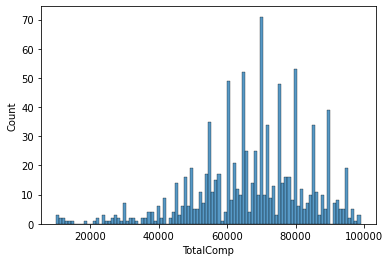

In [63]:
# df["TotalComp"].describe()
sns.histplot(data=df["TotalComp"], bins=100)

In [64]:
df.dtypes
df["Position "]

0                            Software Engineer
1                            Backend Developer
3                           Frontend Developer
4                            Backend Developer
5                                       DevOps
                         ...                  
1244                         Software Engineer
1245                        Frontend Developer
1249    Researcher/ Consumer Insights Analyst 
1251                        Frontend Developer
1252                                    DevOps
Name: Position , Length: 990, dtype: object

In [65]:
df.isna().sum()

Age                                                        21
Gender                                                      5
City                                                        0
Position                                                    2
Total years of experience                                  12
Years of experience in Germany                             24
Seniority level                                             9
Your main technology / programming language               103
Other technologies/programming languages you use often    129
Yearly brutto salary (without bonus and stocks) in EUR      0
Yearly bonus + stocks in EUR                                0
Number of vacation days                                    54
Employment status                                          14
Сontract duration                                          20
Main language at work                                      12
Company size                                               15
Company 

In [66]:
df["Years of experience in Germany"].value_counts(ascending=True) 


1,7                                                      1
0.9                                                      1
25                                                       1
< 1                                                      1
17                                                       1
4 month                                                  1
19                                                       1
26                                                       1
3 months                                                 1
4.5                                                      1
0.1                                                      1
2.6                                                      1
3 (in Poland)                                            1
<1                                                       1
⁰                                                        1
0,3                                                      1
-                                                       

In [67]:
df.duplicated().sum()

13

In [69]:
#replace the commas that are used instead of decimals
df["Total years of experience"].replace(",",".")
df["Years of experience in Germany"].replace(",",".")
#get rid of any non numeric chars
df["Total years of experience"] = df["Total years of experience"].str.extract(r"([+-]? *(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)", expand=False)
df["Years of experience in Germany"] = df["Years of experience in Germany"].str.extract(r"([+-]? *(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)", expand=False)
df["Number of vacation days"] = df["Number of vacation days"].str.extract(r"([+-]? *(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)", expand=False)

In [73]:
# df.dtypes
# df["Number of vacation days"].value_counts(ascending=True)

30 in contract (but theoretically unlimited)      1
37                                                1
0                                                 1
45                                                1
1                                                 1
Unlimited                                         1
24 labour days                                    1
23+                                               1
50                                                1
~25                                               1
3                                                 1
16                                                1
Unlimited                                         1
34                                                1
unlimited                                         1
10                                                1
38                                                1
14                                                2
33                                                2
35          

In [70]:
#now make the columns numeric
df["Age"] = pd.to_numeric(df["Age"])
df["Total years of experience"] = pd.to_numeric(df["Total years of experience"])
df["Years of experience in Germany"] = pd.to_numeric(df["Years of experience in Germany"])

In [17]:
y = df["TotalComp"]
x = df.drop(columns={"TotalComp"})

x_train, x_test, y_train, y_test = train_test_split(x,y)

scaler = MinMaxScaler()
encoder = OneHotEncoder()
estimator = RandomForestRegressor(n_jobs = -1) # ExtraTreesRegressor(n_jobs=-1)

numericFeaturesMeanImpute = ["Age","Total years of experience","Years of experience in Germany","Number of vacation days"]
numericMeanTransformer = Pipeline( steps=[
    ("imputeMean", SimpleImputer(strategy="mean")),
    ("scaler", scaler)
])

numericFeaturesZeroImpute = ["Yearly brutto salary (without bonus and stocks) in EUR","Yearly bonus + stocks in EUR"]
numericZeroTransformer = Pipeline( steps=[
    ("imputeZero", SimpleImputer(strategy="constant", fill_value=0,)),
    ("scaler", scaler)
])

categoricalFeatures = ["Gender","City","Position ","Seniority level","Your main technology / programming language","Other technologies/programming languages you use often",
                    "Employment status", "Сontract duration", "Main language at work","Company size","Company type"]
catergoricalTransformer =  Pipeline( steps=[
    ("impute",SimpleImputer(strategy="most_frequent")),
    ("encoder", encoder)
])

columnPreProcessor = ColumnTransformer( transformers=[
    ("numMean", numericMeanTransformer, numericFeaturesMeanImpute),
    ("numZero", numericZeroTransformer, numericFeaturesZeroImpute),
    ("cat", catergoricalTransformer, categoricalFeatures)
])

pipelineSteps = [("pre", columnPreProcessor), ('est', estimator)]
pipe = Pipeline(steps=pipelineSteps)

pipe.fit(x_train,y_train)
pipe.score(x_test,y_test)

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: '1,5'

# First runs
 1. removed biggest total comp outlier, imputed nans to 0 in bonus

# Answers and Explainations
(Expand/modify as needed)

### Results

### Feature Selection Activities

### Hyperparameter Changes